In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib_venn import venn2, venn2_unweighted
import pandas as pd
import numpy as np
import requests as rq
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from scipy.stats import spearmanr

plt.style.use('seaborn-poster')

In [2]:
utr = pd.read_csv('test_mapper.tsv', sep='\t')
mapper = utr[['Gene Symbol', 'Refseq ID']]
mapper

,Gene Symbol,Refseq ID
0,CDR1as,CDR1as
1,ARF5,ENST00000000233.5
2,M6PR,ENST00000000412.3
3,FKBP4,ENST00000001008.4
4,CYP26B1,ENST00000001146.2
...,...,...
28347,DCAF8,ENST00000610139.1
28348,NT5C3A,ENST00000610140.1
28349,NAA60,ENST00000610180.1
28350,RNASE11,ENST00000610205.1


In [3]:
mirdb = pd.read_csv('test_mirdb.tsv', sep='\t')
mirdb = mirdb[mirdb['Target Score'] >= 80]
mirdb['mir_mirdb'] = mirdb['pre-miRNA'] + '.' + mirdb.isomiRNA

mirdb = mirdb[['Gene Symbol', 'mir_mirdb', 'Target Score']]
mirdb = mirdb.set_index('Gene Symbol').rename(columns={'Target Score': 'score_mirdb'})
mirdb = mirdb.join(mapper.set_index('Gene Symbol'), on='Gene Symbol').reset_index()
not_mapped_mirdb = set(mirdb[mirdb['Refseq ID'].isna()]['Gene Symbol'])
mirdb

,Gene Symbol,mir_mirdb,score_mirdb,Refseq ID
0,CDK19,hsa-mir-148a.hsa-miR-148a-3p|0,100,ENST00000368911.3
1,SOS2,hsa-mir-148a.hsa-miR-148a-3p|0,100,ENST00000216373.5
2,KMT2A,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000534358.1
3,UBE2D3,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000343106.5
4,UBE2D3,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000453744.2
...,...,...,...,...
1209,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000222390.5
1210,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000354224.6
1211,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000423064.2
1212,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000444829.2


In [4]:
ts = pd.read_csv('test_ts.tsv', sep='\t', index_col=0, header=None).rename(columns={1: 'mir_ts', 2: 'score_ts'})
# ts = ts.nlargest(mirdb.shape[0], 'score_ts')
ts = ts.join(mapper.set_index('Refseq ID')).reset_index().rename(columns={'index': 'Refseq ID'})
not_mapped_ts = set(ts[ts['Gene Symbol'].isna()]['Refseq ID'])
ts

,Refseq ID,mir_ts,score_ts,Gene Symbol
0,ENST00000000233.5,hsa-mir-148a.hsa-miR-148a-3p|0,-0.1549,ARF5
1,ENST00000000412.3,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.0264,M6PR
2,ENST00000001008.4,hsa-mir-148a.hsa-miR-148a-3p|0,-0.0145,FKBP4
3,ENST00000001008.4,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.1980,FKBP4
4,ENST00000001146.2,hsa-mir-148a.hsa-miR-148a-3p|0,-0.9050,CYP26B1
...,...,...,...,...
20370,ENST00000609948.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.4350,COQ4
20371,ENST00000610020.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.0067,RPAP2
20372,ENST00000610020.1,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.0023,RPAP2
20373,ENST00000610125.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.1750,HIST2H4A


In [5]:
len(not_mapped_mirdb), len(not_mapped_ts)

(5, 0)

In [6]:
not_mapped_mirdb

{'ADAMTS6', 'CEBPZOS', 'KDM7A', 'SIK1B', 'ZNF518A'}

In [7]:
def retrieve_uniprot_ensembl_id(acess):
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&reviewed=true&gene={acess}&organism=Homo%20sapiens"

    r = rq.get(requestURL, headers={ "Accept" : "application/json"})
    responseBody = r.json()

    names = set()
    for prot in responseBody:
        try:
            for acc in prot['dbReferences']:    
                if acc['type'] == 'Ensembl':
                    names.add(acc['properties']['gene ID'])
        except KeyError:
            continue

    if len(names) == 1:
        return names.pop()
    else:
        return names

In [8]:
def retrieve_ensembl_symbol(acess):
    url = f'http://feb2014.archive.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g={acess};r=10:97889472-97965044'
    response = rq.get(url).text
    soup = BeautifulSoup(response, 'html.parser')
    gene_symbol = soup.find('li', {'class': "gene active short_tab"}).contents[0]['title'].split(': ')[1]
    return gene_symbol

In [9]:
print(mirdb.shape)
mirdb = mirdb.dropna()
mirdb

(1214, 4)


,Gene Symbol,mir_mirdb,score_mirdb,Refseq ID
0,CDK19,hsa-mir-148a.hsa-miR-148a-3p|0,100,ENST00000368911.3
1,SOS2,hsa-mir-148a.hsa-miR-148a-3p|0,100,ENST00000216373.5
2,KMT2A,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000534358.1
3,UBE2D3,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000343106.5
4,UBE2D3,hsa-mir-148a.hsa-miR-148a-3p|0,99,ENST00000453744.2
...,...,...,...,...
1209,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000222390.5
1210,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000354224.6
1211,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000423064.2
1212,HGF,hsa-mir-203a.hsa-miR-203a-3p|+1,80,ENST00000444829.2


In [10]:
ts

,Refseq ID,mir_ts,score_ts,Gene Symbol
0,ENST00000000233.5,hsa-mir-148a.hsa-miR-148a-3p|0,-0.1549,ARF5
1,ENST00000000412.3,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.0264,M6PR
2,ENST00000001008.4,hsa-mir-148a.hsa-miR-148a-3p|0,-0.0145,FKBP4
3,ENST00000001008.4,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.1980,FKBP4
4,ENST00000001146.2,hsa-mir-148a.hsa-miR-148a-3p|0,-0.9050,CYP26B1
...,...,...,...,...
20370,ENST00000609948.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.4350,COQ4
20371,ENST00000610020.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.0067,RPAP2
20372,ENST00000610020.1,hsa-mir-203a.hsa-miR-203a-3p|+1,-0.0023,RPAP2
20373,ENST00000610125.1,hsa-mir-148a.hsa-miR-148a-3p|0,-0.1750,HIST2H4A


In [11]:
mirdb[mirdb.duplicated(subset=['Refseq ID', 'mir_mirdb'], keep=False)]

,Gene Symbol,mir_mirdb,score_mirdb,Refseq ID


In [12]:
ts[ts.duplicated(subset=['Refseq ID', 'mir_ts'], keep=False)]

,Refseq ID,mir_ts,score_ts,Gene Symbol


In [13]:
def print_fig(sets, title, ax):
    v = venn2_unweighted(subsets=sets, set_labels=('miRDB', 'TargetScan'), set_colors=('r', 'g'), ax=ax)
    ax.set_title(title, fontsize=30)
    v.set_labels[0].set_fontsize(25)
    v.set_labels[1].set_fontsize(25)
    for i in '10,11,01'.split(','):
        v.get_label_by_id(i).set_fontsize(25)


def get_figures_for_mirna(mirdb, ts):
    mirna_name = ', '.join(ts.mir_ts.str.split('.').str[1].unique().tolist())
    print(mirna_name)
    
    mirdb_set_ref = set(mirdb['Refseq ID'] + '&' + mirdb.mir_mirdb)
    ts_set_ref = set(ts['Refseq ID'] + '&' + ts.mir_ts)

    mirdb_set_sym = set(mirdb['Gene Symbol'] + '&' + mirdb.mir_mirdb)
    ts_set_sym = set(ts['Gene Symbol'] + '&' + ts.mir_ts)

    print(f"Refseq ID interactions count: miRDB = {len(mirdb_set_ref)}, TargetScan = {len(ts_set_ref)}")
    print(f"Gene Symbol interactions count: miRDB = {len(mirdb_set_sym)}, TargetScan = {len(ts_set_sym)}")
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(mirna_name, fontsize=30)
    print_fig([mirdb_set_ref, ts_set_ref], 'Refseq Id interactions', ax[0])
    print_fig([mirdb_set_sym, ts_set_sym], 'Gene Symbol interactions', ax[1])
    
    common_indexes = pd.Series(list(mirdb_set_ref & ts_set_ref)).str.split('&').tolist()
    t = ts.set_index(['Refseq ID', 'mir_ts']).loc[common_indexes].score_ts
    m = mirdb.set_index(['Refseq ID', 'mir_mirdb']).loc[common_indexes].score_mirdb
    df = pd.concat([m, t], axis=1)
    print('Spearmanr =', spearmanr(df.to_numpy())[0])

    sns.regplot(data=df, x='score_ts', y='score_mirdb', ax=ax[2])
    plt.tight_layout()
    plt.show()
    
    fig = sns.jointplot(x='score_ts', y="score_mirdb", data=df, alpha=0.2)
    fig.fig.set_figwidth(6)
    fig.fig.set_figheight(6)

hsa-miR-148a-3p|0, hsa-miR-203a-3p|+1
Refseq ID interactions count: miRDB = 1209, TargetScan = 20375
Gene Symbol interactions count: miRDB = 790, TargetScan = 16672
Spearmanr = -0.19948564268149996


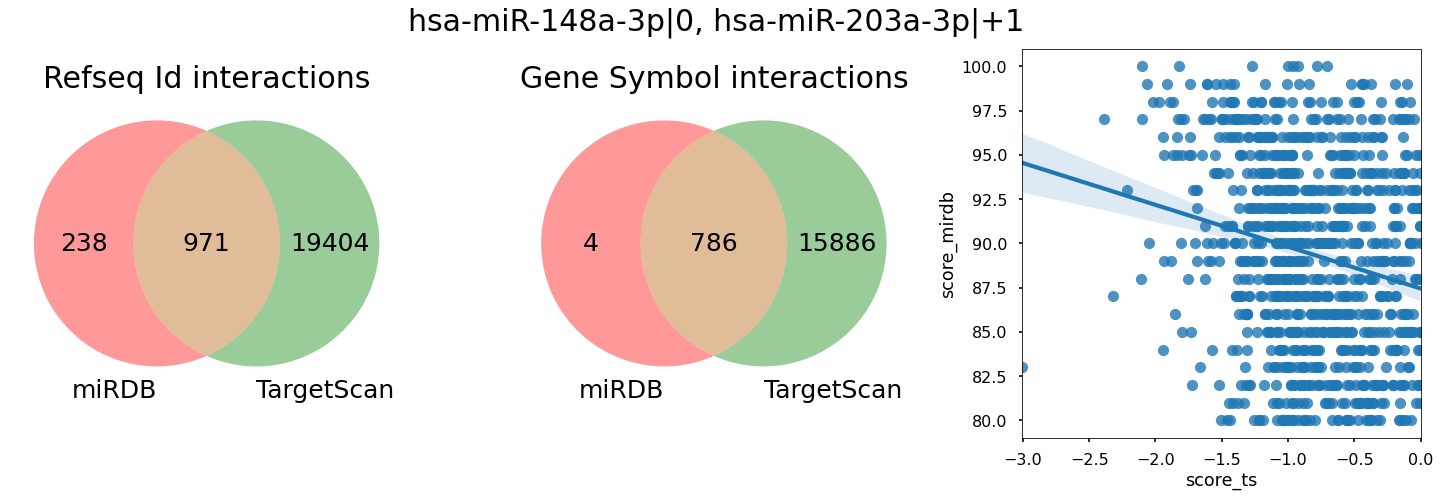

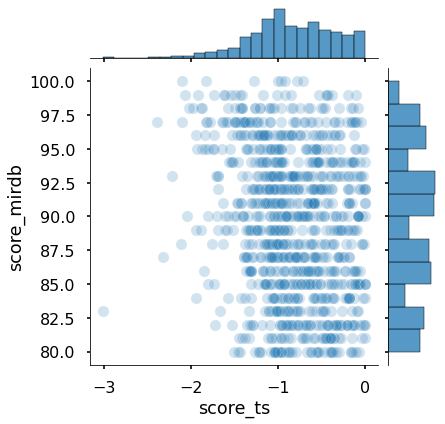

In [14]:
get_figures_for_mirna(mirdb, ts)

hsa-miR-148a-3p|0
Refseq ID interactions count: miRDB = 531, TargetScan = 8735
Gene Symbol interactions count: miRDB = 342, TargetScan = 7247
Spearmanr = -0.19922032555822583


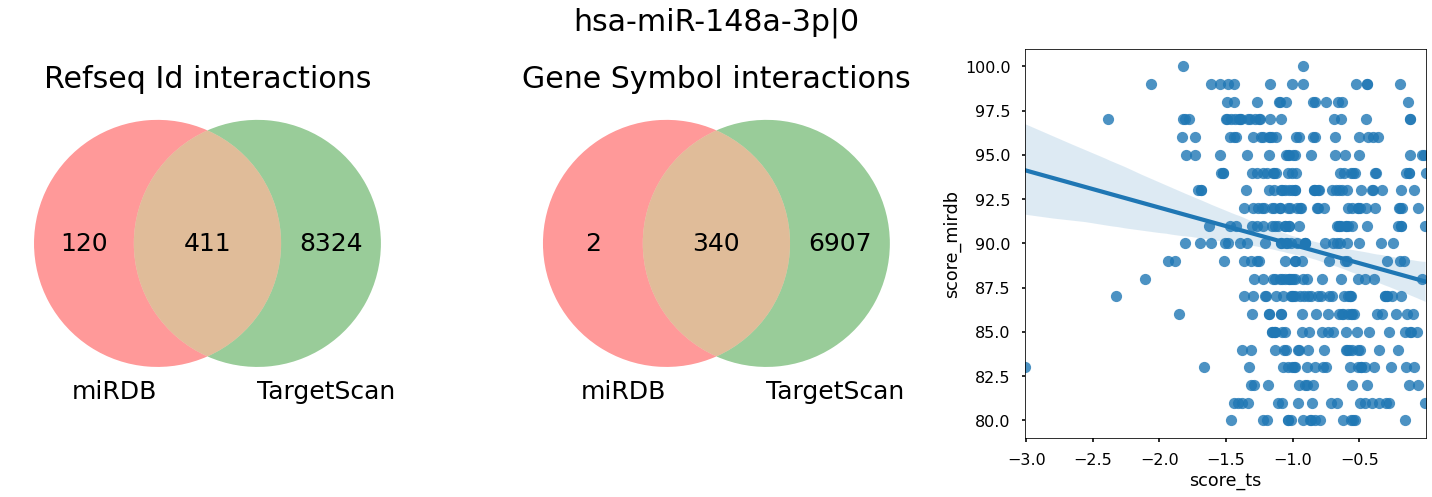

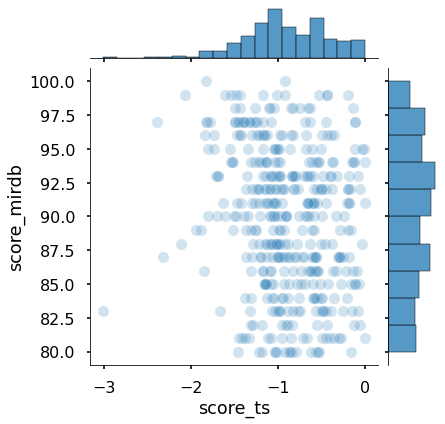

In [15]:
t148 = ts[ts.mir_ts == 'hsa-mir-148a.hsa-miR-148a-3p|0']
m148 = mirdb[mirdb.mir_mirdb == 'hsa-mir-148a.hsa-miR-148a-3p|0']
get_figures_for_mirna(m148, t148)

hsa-miR-203a-3p|+1
Refseq ID interactions count: miRDB = 678, TargetScan = 11640
Gene Symbol interactions count: miRDB = 448, TargetScan = 9425
Spearmanr = -0.19337090132546478


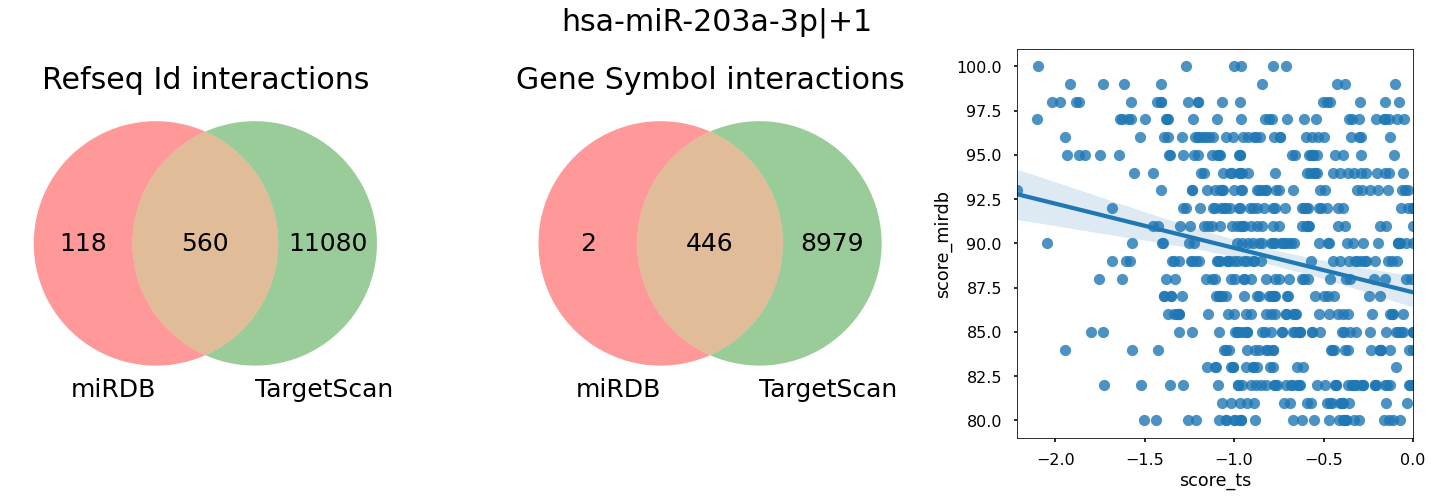

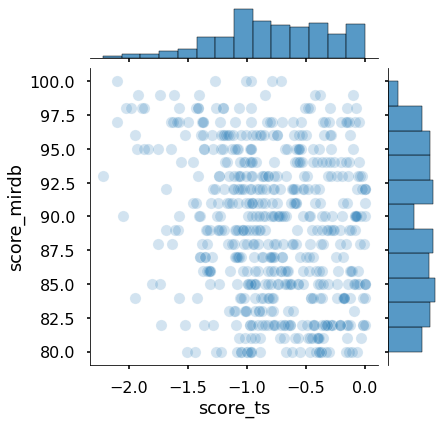

In [16]:
t203 = ts[ts.mir_ts == 'hsa-mir-203a.hsa-miR-203a-3p|+1']
m203 = mirdb[mirdb.mir_mirdb == 'hsa-mir-203a.hsa-miR-203a-3p|+1']
get_figures_for_mirna(m203, t203)

In [17]:
utr = pd.read_csv('test_utr.tsv', sep='\t', index_col=0)
utr.loc[ts.nlargest(1, 'score_ts')['Refseq ID'].tolist()[0]]

Gene ID                                         ENSG00000071282.7
Gene Symbol                                                 LMCD1
Species ID                                                   9606
UTR sequence    AGG--G---CUGCCCAC--CCAC------AGCCAGAAUCCACAGGA...
Name: ENST00000157600.3, dtype: object

In [18]:
m148 = 'ucagugcacuacagaacuuugu'.upper()
m148

'UCAGUGCACUACAGAACUUUGU'